## Analysis of (biased) Yelp dataset 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import itertools
from pprint import pprint

import numpy as np
import numpy.random as npr
import pandas as pd
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

In [3]:
from experiments.baseline_experiment_util import calc_train_importance_weights
from experiments.baseline_experiment_util import importance_weighted_precision_recall, importance_weighted_pr_curve
from experiments.baseline_experiment_util import setup_baseline_data, area_under_pr_curve
from sklearn.metrics import confusion_matrix

from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [4]:
# Load data
#biased_data = setup_baseline_data(data_path='data', train_regime='biased', test_regime='gold', random_seed=0)
#gold_data = setup_baseline_data(data_path='data', train_regime='gold', test_regime='gold', random_seed=0)
#silver_data = setup_baseline_data(data_path='data', train_regime='silver', test_regime='gold', random_seed=0)


In [5]:
data_path='./data'
biased = pd.read_csv(os.path.join(data_path, 'biased.csv'), encoding='utf8')


In [6]:
biased.head()

,url,date,text,is_foodborne,is_multiple
0,http://www.yelp.com/biz/antique-garage-new-york,2012-07-02,I wish I could give zero stars here. I have be...,Yes,No
1,http://www.yelp.com/biz/mezcals-mexican-restau...,2012-07-02,This is hands down the worst dining experience...,Yes,Yes
2,http://www.yelp.com/biz/red-flame-diner-coffee...,2012-07-04,Got food poisoning after my last visit. Not fun!,Yes,No
3,http://www.yelp.com/biz/taro-sushi-brooklyn,2012-07-05,"""Let me start out by saying that I used to LOV...",Yes,No
4,http://www.yelp.com/biz/yakitori-taisho-new-york,2012-07-06,"""CONS:\n*Revolting food -- and I do mean that ...",Yes,No


In [27]:
# Preprocess Dataset
biased['is_foodborne'] = biased['is_foodborne'].map({'Yes':1, 'No':0})
biased['is_multiple'] = biased['is_multiple'].map({'Yes':1, 'No':0})
biased['date'] = pd.to_datetime(biased['date'])
biased['all'] = 1  # help column 

# Add 'day' column
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
biased['day'] = biased['date'].map(lambda x: days[x.dayofweek])

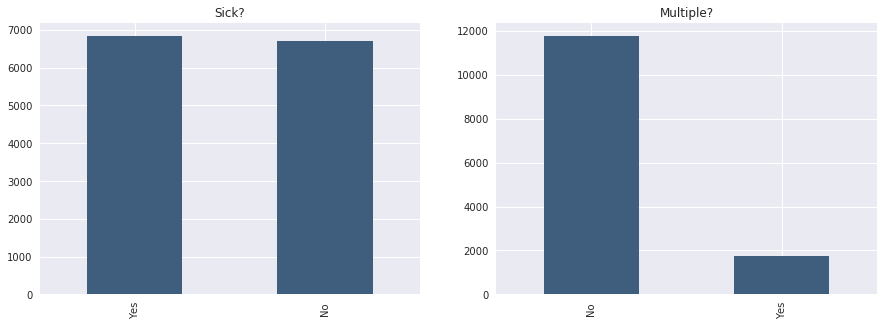

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
biased['is_foodborne'].value_counts().plot(kind='bar', color='#3F5D7D', title='Sick?', ax=axes[0])
biased['is_multiple'].value_counts().plot(kind='bar', color='#3F5D7D', title='Multiple?', ax=axes[1])

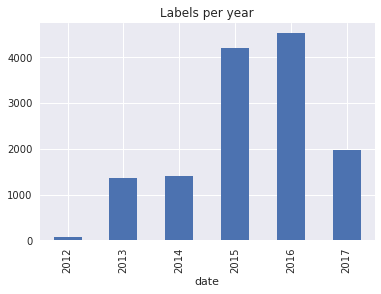

In [32]:
biased.groupby(biased.date.dt.year).count()['url'].plot(kind="bar", title='Labels per year')

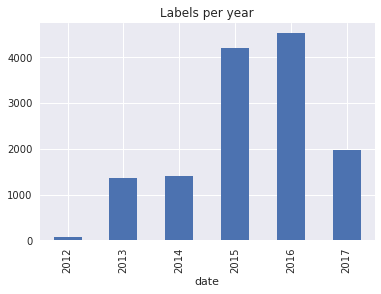

In [62]:
biased.groupby(biased['date'].dt.year).count()['url'].plot(kind="bar", title='Labels per year')

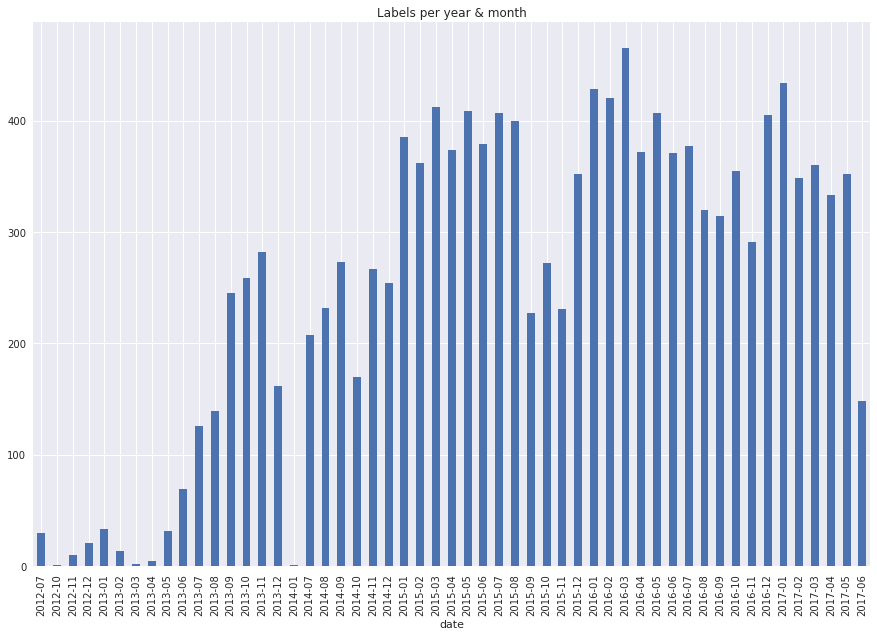

In [61]:
biased.groupby(biased['date'].dt.to_period("M")).count()['url'].plot(kind="bar", title='Labels per year & month', figsize=(15,10))

Note: 
* Some months are missing:
    * 2012 Jan - June, August, September
    * 2014 Feb - June
* Not uniform distribution of labels - month level

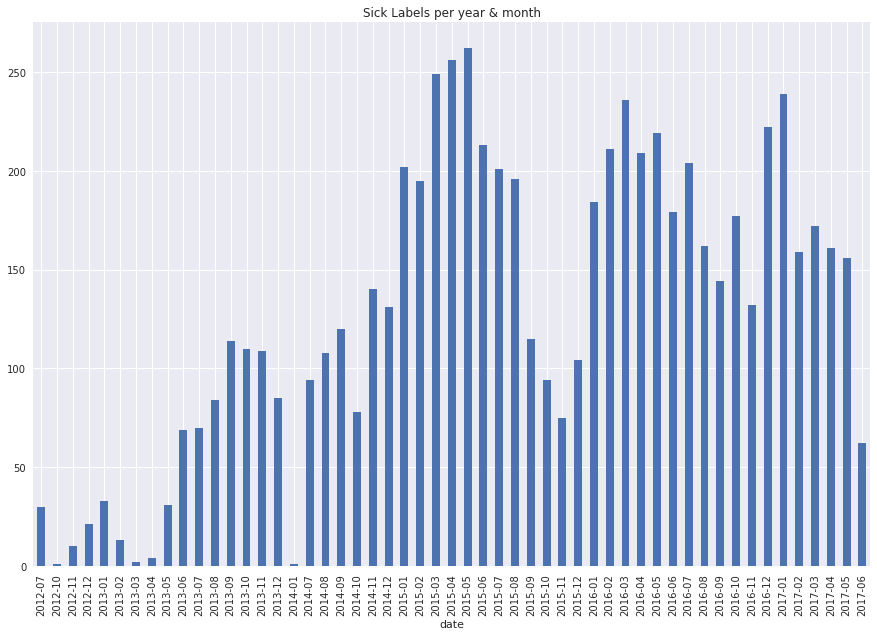

In [64]:
biased.groupby(biased['date'].dt.to_period("M")).sum()['is_foodborne'].plot(kind="bar", title='Sick Labels per year & month', figsize=(15,10))

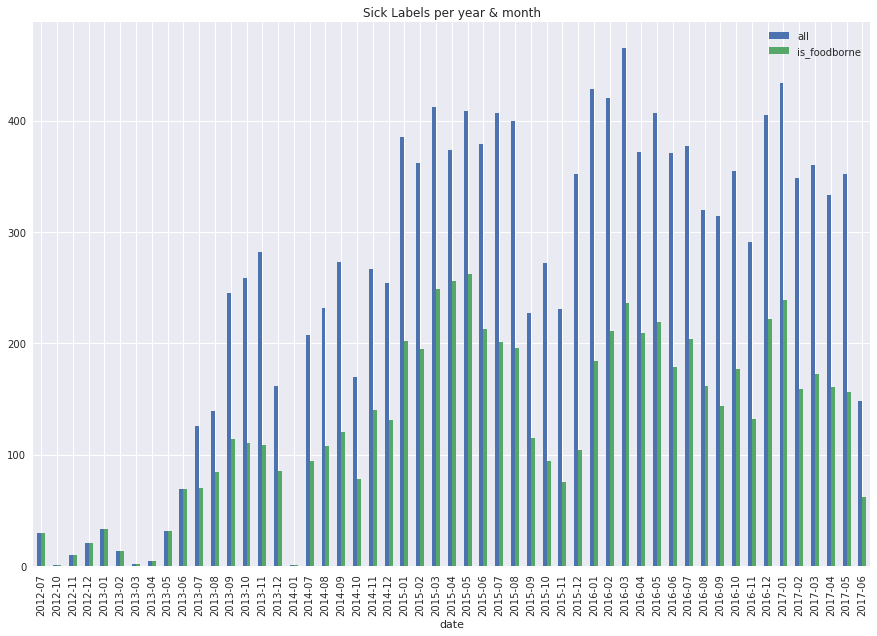

In [68]:
biased.groupby(biased['date'].dt.to_period("M")).sum()[['all','is_foodborne']].plot(kind="bar", title='Sick Labels per year & month', figsize=(15,10))

In [90]:
biased['day'] = biased['date'].map(lambda x: days[x.dayofweek])

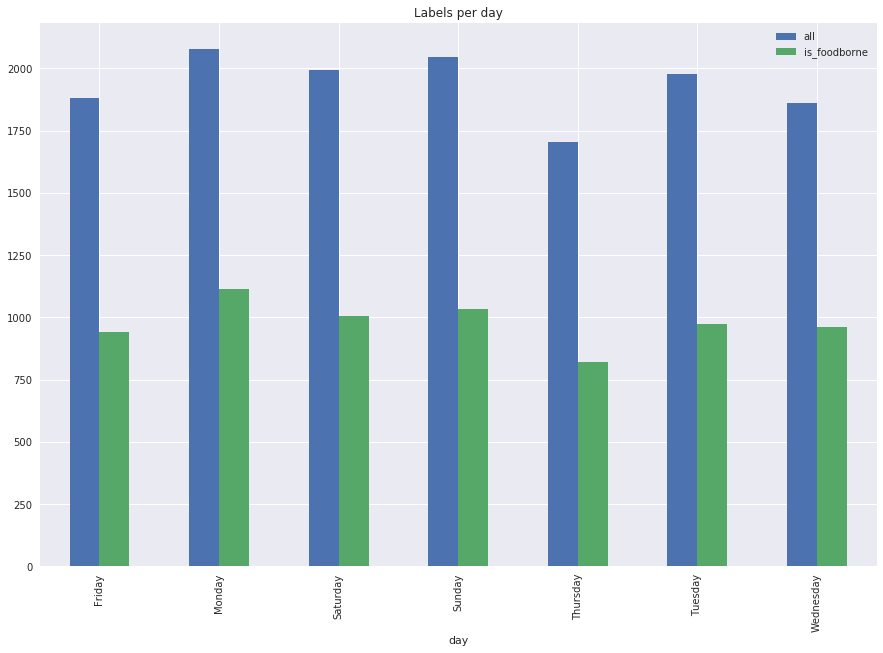

In [93]:
biased.groupby(biased['day']).sum()[['all','is_foodborne']].plot(kind="bar", title='Labels per day', figsize=(15,10))